Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**
- Get **ROC AUC** (Receiver Operating Characteristic, Area Under the Curve)

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries

- category_encoders
- ipywidgets
- matplotlib
- numpy
- pandas
- scikit-learn
- seaborn

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

#### If you have matplotlib version 3.1.1 then seaborn heatmaps will be cut off

Because of this issue: [sns.heatmap top and bottom boxes are cut off](https://github.com/mwaskom/seaborn/issues/1773)

> This was a matplotlib regression introduced in 3.1.1 which has been fixed in 3.1.2 (still forthcoming). For now the fix is to downgrade matplotlib to a prior version.

This code checks your matplotlib version:

In [35]:
import matplotlib
print(matplotlib.__version__)

3.1.2


If you have version 3.1.1, you can downgrade if you want, but you don't have to, I just want you to be aware of the issue.

# Get and interpret the confusion matrix for classification models

## Overview

First, load the Tanzania Waterpumps data and fit a model. (This code isn't new, we've seen it all before.)

In [36]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8140409527789386


In [4]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8111854018665552


In [5]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8093745647026048


In [0]:
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission[target] = y_pred

submission.to_csv('lecture_predictions.csv', index=False)

from google.colab import files
files.download('lecture_predictions.csv')

## Follow Along

Scikit-learn's [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) function just returns a matrix of numbers, which is hard to read.

Scikit-learn docs have an example [plot_confusion_matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) function. The output looks good, but the code is long and hard to understand. It's written just with numpy and matplotlib.

We can write our own function using pandas and seaborn.  The code will be shorter and easier to understand. Let's write the function iteratively.

In [37]:
# check version
import sklearn
sklearn.__version__

'0.22.1'

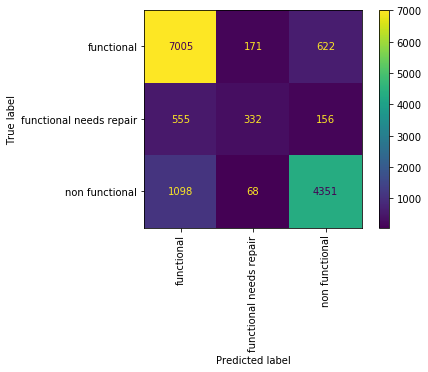

In [38]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation='vertical', values_format='.0f');

#### How many correct predictions were made?

In [39]:
correct_predictions = 7005 + 332 + 4351
correct_predictions

11688

#### How many total predictions were made?

In [40]:
total_predictions = 7005 + 171 + 622 + 555 + 332 + 156 + 1098 + 68 + 4351
total_predictions

14358

#### What was the classification accuracy?

In [41]:
correct_predictions / total_predictions

0.8140409527789386

In [42]:
pipeline.score(X_val, y_val)

0.8140409527789386

In [43]:
y_pred = pipeline.predict(X_val)
sum(y_pred == y_val) / len(y_pred)

0.8140409527789386

# Use classification metrics: precision, recall

## Overview

[Scikit-Learn User Guide — Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [44]:
from sklearn.metrics import classification_report

cr = classification_report(y_val, y_pred)
print(cr)

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



#### Wikipedia, [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)

> Both precision and recall are based on an understanding and measure of relevance.

> Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

> High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="400">

## Follow Along

#### [We can get precision & recall from the confusion matrix](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



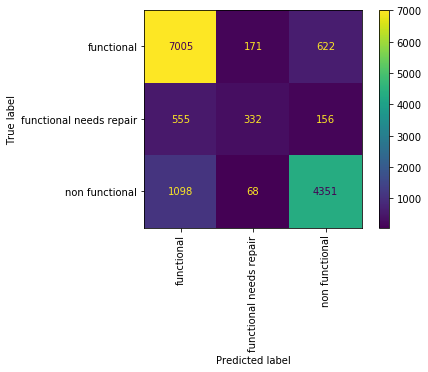

In [45]:
cm = plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')
cm;
print(cr)

#### How many correct predictions of "non functional"?

In [0]:
# correct predictions for class
# bottom right corner
correct_non_functional = 4351

#### How many total predictions of "non functional"?

In [0]:
# total predictions for class
# sum predictions for class (3rd column)
total_non_functional = 622 + 156 + 4351

#### What's the precision for "non functional"?

In [48]:
# correct predictions for class / total predictions for class
# bottom right corner / sum predictions for class (3rd column)
precision_non_functional = correct_non_functional / total_non_functional

print(f'{precision_non_functional:.2f}')

0.85


#### How many actual "non functional" waterpumps?

In [0]:
# actual occurence of class
# sum true for class (3rd row)
actual_non_functional = 1098 + 68 + 4351

#### What's the recall for "non functional"?

In [50]:
# correct predictions for class / actual occurence of class
# bottom right corner / sum true for class (3rd row)
recall_non_functional = correct_non_functional / actual_non_functional

print(f'{recall_non_functional:.2f}')

0.79


# Understand the relationships between precision, recall, thresholds, and predicted probabilities, to help make decisions and allocate budgets

## Overview

### Imagine this scenario...

Suppose there are over 14,000 waterpumps that you _do_ have some information about, but you _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

In [51]:
len(test)

14358

**You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.** You want to predict, which 2,000 are most likely non-functional or in need of repair, to help you triage and prioritize your waterpump inspections.

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

In [53]:
len(train) + len(val)

59400

Based on this historical data, if you randomly chose waterpumps to inspect, then about 46% of the waterpumps would need repairs, and 54% would not need repairs.

In [52]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [54]:
2000 * 0.46

920.0

**Can you do better than random at prioritizing inspections?**

In this scenario, we should define our target differently. We want to identify which waterpumps are non-functional _or_ are functional but needs repair:

In [55]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

We already made our validation set the same size as our test set.

In [56]:
len(val) == len(test)

True

We can refit our model, using the redefined target.

Then make predictions for the validation set.

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

## Follow Along

#### Look at the confusion matrix:

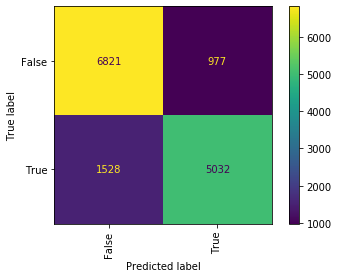

In [58]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

#### How many total predictions of "True" ("non functional" or "functional needs repair") ?

In [59]:
total_predictions = 5032 + 977
total_predictions

6009

### We don't have "budget" to take action on all these predictions

- But we can get predicted probabilities, to rank the predictions. 
- Then change the threshold, to change the number of positive predictions, based on our budget.

### Get predicted probabilities and plot the distribution

In [60]:
# discrete prdictions
pipeline.predict(X_val)

array([ True,  True, False, ..., False,  True, False])

In [61]:
# predicted probabilities
pipeline.predict_proba(X_val)

array([[0.  , 1.  ],
       [0.26, 0.74],
       [0.9 , 0.1 ],
       ...,
       [0.91, 0.09],
       [0.41, 0.59],
       [0.98, 0.02]])

In [62]:
# predicted probabilities for positive class

pipeline.predict_proba(X_val)[:, 1]

array([1.  , 0.74, 0.1 , ..., 0.09, 0.59, 0.02])

In [63]:
# make predicted probabilities into discrete predictions
# apply a threshold

pipeline.predict_proba(X_val)[:, 1] > 0.5

array([ True,  True, False, ..., False,  True, False])

In [66]:
# change the threshold

pipeline.predict_proba(X_val)[:, 1] > 0.7

array([ True,  True, False, ..., False, False, False])

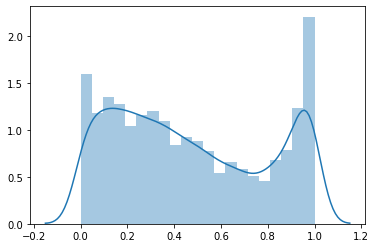

In [67]:
import seaborn as sns

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba);

### Change the threshold

False    12325
True      2033
dtype: int64

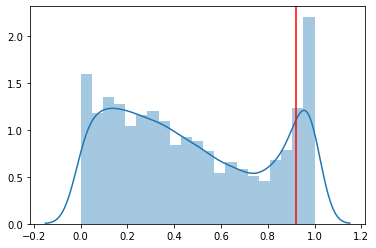

In [80]:
threshold = 0.92

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [81]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def my_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### Or, get exactly 2,000 positive predictions

Identify the 2,000 waterpumps in the validation set with highest predicted probabilities.

In [83]:
results = pd.DataFrame({'y_val':y_val, 'y_pred_proba':y_pred_proba})
results

,y_val,y_pred_proba
58046,True,1.00
41184,True,0.74
27587,False,0.10
53109,False,0.05
7245,True,0.55
...,...,...
18760,False,0.68
36059,True,0.88
4759,False,0.09
43621,False,0.59


In [85]:
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]
top2000

,y_val,y_pred_proba
58046,True,1.00
6288,True,1.00
27470,True,1.00
41452,True,1.00
3337,True,1.00
...,...,...
30643,True,0.93
14010,True,0.93
22524,True,0.93
55253,True,0.93


Most of these top 2,000 waterpumps will be relevant recommendations, meaning `y_val==True`, meaning the waterpump is non-functional or needs repairs.

Some of these top 2,000 waterpumps will be irrelevant recommendations, meaning `y_val==False`, meaning the waterpump is functional and does not need repairs.

Let's look at a random sample of 50 out of these top 2,000:

In [86]:
top2000.sample(n=50)

,y_val,y_pred_proba
33951,True,0.97
34769,True,0.97
24671,True,0.96
56070,True,0.97
18661,True,0.96
3465,True,0.97
39061,True,0.96
12209,True,0.99
29999,False,0.96
50686,True,0.93


So how many of our recommendations were relevant? ...

In [88]:
trips = 2000
print(f'baseline: {trips * .46} waterpump repairs in {trips} trips.')

relevant_recommendations = top2000['y_val'].sum()
print(f'with model: predict {relevant_recommendations} waterpump repairs in {trips} trips.')

baseline: 920.0 waterpump repairs in 2000 trips.
with model: predict 1972 waterpump repairs in 2000 trips.


What's the precision for this subset of 2,000 predictions?

In [91]:
1972 / 2000
precision_at_k_2000 = relevant_recommendations / trips
print(f'precision at k={trips}: {precision_at_k_2000}')

precision at k=2000: 0.986


### In this scenario ... 

Accuracy _isn't_ the best metric!

Instead, change the threshold, to change the number of positive predictions, based on the budget. (You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.)

Then, evaluate with the precision for "non functional"/"functional needs repair".

This is conceptually like **Precision@K**, where k=2,000.

Read more here: [Recall and Precision at k for Recommender Systems: Detailed Explanation with examples](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

> Precision at k is the proportion of recommended items in the top-k set that are relevant

> Mathematically precision@k is defined as: `Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)`

> In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

We asked, can you do better than random at prioritizing inspections?

If we had randomly chosen waterpumps to inspect, we estimate that only 920 waterpumps would be repaired after 2,000 maintenance visits. (46%)

But using our predictive model, in the validation set, we succesfully identified over 1,900 waterpumps in need of repair!

So we will use this predictive model with the dataset of over 14,000 waterpumps that we _do_ have some information about, but we _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

We will predict which 2,000 are most likely non-functional or in need of repair.

We estimate that approximately 1,900 waterpumps will be repaired after these 2,000 maintenance visits.

So we're confident that our predictive model will help triage and prioritize waterpump inspections.

### But ...

This metric (~1,900 waterpumps repaired after 2,000 maintenance visits) is specific for _one_ classification problem and _one_ possible trade-off.

Can we get an evaluation metric that is generic for _all_ classification problems and _all_ possible trade-offs?

Yes — the most common such metric is **ROC AUC.**

## Get ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. **The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.**"

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures **how well a classifier ranks predicted probabilities.** So, when you get your classifier’s ROC AUC score, you need to **use predicted probabilities, not discrete predictions.**

ROC AUC ranges **from 0 to 1.** Higher is better. A naive majority class **baseline** will have an ROC AUC score of **0.5.** 

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

In [0]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [93]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.00
1,0.000385,0.062652,1.00
2,0.000641,0.114787,0.99
3,0.000769,0.155793,0.98
4,0.001282,0.196037,0.97
...,...,...,...
102,0.882662,0.996341,0.04
103,0.904976,0.997104,0.03
104,0.930239,0.998171,0.02
105,0.954604,0.998933,0.01


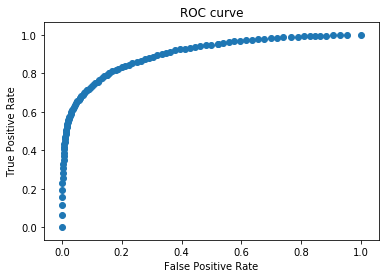

In [94]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [95]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9024268359147749

**Recap:** ROC AUC measures how well a classifier ranks predicted probabilities. So, when you get your classifier’s ROC AUC score, you need to use predicted probabilities, not discrete predictions. 

Your code may look something like this:

```python
from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_test_transformed)[:, -1] # Probability for last class
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))
```

ROC AUC ranges from 0 to 1. Higher is better. A naive majority class baseline will have an ROC AUC score of 0.5.